<a href="https://colab.research.google.com/github/mehularora8/Bank-Management-System-in-CPP/blob/master/Final_proj_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
from google.colab import drive
drive.mount('/content/drive')

# FOLDERNAME = 'Stanford/Stanford 20-21/CS 231N/Project/'
FOLDERNAME = 'cs231n/Final\ Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/Final Project


In [88]:
import os
import random
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [89]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [90]:
model = nn.Sequential (
    # Input is 3 x 256 x 256
    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 2),
    # 32 x 256 x 256
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.01),
    nn.Dropout(p = 0.2),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    # 32 x 128 x 128
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 2),
    # 64 x 128 x 128
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.01),
    nn.Dropout(p = 0.2),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    # 64 x 64 x 64
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
    # 128 x 64 x 64
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.01),
    nn.Dropout(p = 0.2),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    # 128 x 32 x 32
    Flatten(),
    nn.Linear(128 * 32 * 32, 1000),
    nn.Linear(1000, 4),
)

def weight_initialization(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)


model.apply(weight_initialization)

if torch.cuda.is_available():
    print("Switching to cuda")
    model.cuda()

print(model)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas = (0.5, 0.999))
criterion = nn.CrossEntropyLoss().cuda()

Switching to cuda
Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0.2, inplace=False)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0.2, inplace=False)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): Dropout(p=0.2, inplace=False)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatt

In [91]:
IMAGE_SIZE = 256
loader = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(0, 1)
            ])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    return image.cuda()  # If using GPU

def image_loader_single(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.cuda()  # If using GPU

In [92]:
# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
# Not including translation
transformer = transforms.Compose([
                transforms.RandomApply(nn.ModuleList([transforms.RandomRotation(5)]), p = 0.5),
                transforms.RandomHorizontalFlip(p = 0.5),
                transforms.RandomGrayscale(p = 0.2),
                transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)]), p = 0.8),
            ])

In [93]:
class WorkoutImagesDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        image = image_loader(img_path)
        
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

dataset = WorkoutImagesDataset("workout_annotations.csv", "dataset/new_dataset", transform = transformer)

# test_dataset, train_dataset = random_split(dataset, [6, 54])

# test_dataloader = DataLoader(test_dataset, batch_size = 6, shuffle = True, num_workers = 0)
# train_dataloader = DataLoader(train_dataset, batch_size = 6, shuffle = True, num_workers = 0)

# train_features, train_labels = next(iter(train_dataloader))
# test_features, test_labels = next(iter(test_dataloader))

# print(train_features.shape, train_labels.shape)

In [94]:
losses = []

for epoch in range(20):  # loop over the dataset a lot of times

    # Multiple instantiations to get augmented dataset every time
    dataset = WorkoutImagesDataset("workout_annotations.csv", "dataset/new_dataset", transform = transformer)

    test_dataset, train_dataset = random_split(dataset, [4, 56])

    test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = True, num_workers = 0)
    train_dataloader = DataLoader(train_dataset, batch_size = 56, shuffle = True, num_workers = 0)

    print('STARTING EPOCH: ', epoch)

    # running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available:
            inputs, labels = inputs.to(device), labels.to(device)

        # show images
        # imshow(torchvision.utils.make_grid(inputs))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        # running_loss += loss.item()
        print('[Epoch %d, Mini-batch %d] loss: %.3f' %
                (epoch + 1, i + 1, loss))
        
    # running_loss = 0.0

print('Finished Training')

STARTING EPOCH:  0
[Epoch 1, Mini-batch 1] loss: 3.263
STARTING EPOCH:  1
[Epoch 2, Mini-batch 1] loss: 1173.784
STARTING EPOCH:  2
[Epoch 3, Mini-batch 1] loss: 2192.648
STARTING EPOCH:  3
[Epoch 4, Mini-batch 1] loss: 1914.048
STARTING EPOCH:  4
[Epoch 5, Mini-batch 1] loss: 800.210
STARTING EPOCH:  5
[Epoch 6, Mini-batch 1] loss: 529.613
STARTING EPOCH:  6
[Epoch 7, Mini-batch 1] loss: 124.260
STARTING EPOCH:  7
[Epoch 8, Mini-batch 1] loss: 364.426
STARTING EPOCH:  8
[Epoch 9, Mini-batch 1] loss: 197.248
STARTING EPOCH:  9
[Epoch 10, Mini-batch 1] loss: 175.780
STARTING EPOCH:  10
[Epoch 11, Mini-batch 1] loss: 93.973
STARTING EPOCH:  11
[Epoch 12, Mini-batch 1] loss: 82.273
STARTING EPOCH:  12
[Epoch 13, Mini-batch 1] loss: 36.715
STARTING EPOCH:  13
[Epoch 14, Mini-batch 1] loss: 12.772
STARTING EPOCH:  14
[Epoch 15, Mini-batch 1] loss: 7.193
STARTING EPOCH:  15
[Epoch 16, Mini-batch 1] loss: 10.055
STARTING EPOCH:  16
[Epoch 17, Mini-batch 1] loss: 8.014
STARTING EPOCH:  17
[Epo

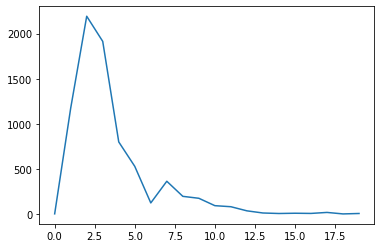

In [95]:
plt.plot(range(len(losses)), losses)

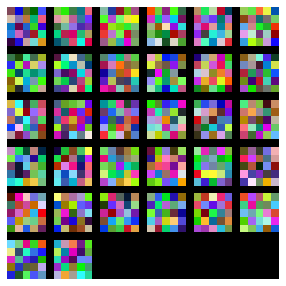

In [96]:
from math import ceil, sqrt

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """

    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                img = img.cpu().detach().numpy()
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

grid = visualize_grid(torch.transpose(torch.transpose(model[0].weight, 1, 2), 2, 3)) # N, C, H, W -> N, H, W, C
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()


In [97]:
PATH = './trained.pth'
torch.save(model.state_dict(), PATH)


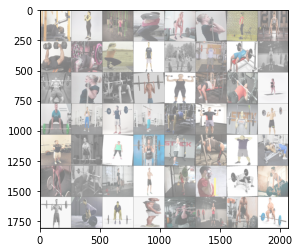

    0     3     1     1     2     1     3     2     0     0     3     3     2     1     0     3     0     1     0     1     1     0     0     3     2     3     1     1


In [98]:
# functions to show an image
train_batch_size = 28

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = (0, 1, 2, 3)

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(train_batch_size)))

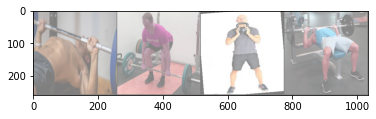

GroundTruth:      0     2     3     0
Predicted:      0     2     3     0


In [99]:
test_batch_size = 4

dataiter = iter(test_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(test_batch_size)))

model.load_state_dict(torch.load(PATH))
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(test_batch_size)))

In [136]:
### Print accuracy ###
correct = 0
total = 0

test_predicted = None
test_labels = None

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, test_labels = data
        
        images, test_labels = images.to(device), test_labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, test_predicted = torch.max(outputs.data, 1)

        if torch.cuda.is_available:
            outputs = outputs.to(device)
            test_predicted = test_predicted.to(device)

        total += test_labels.size(0)
        correct += (test_predicted == test_labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 100 %


In [101]:
### accuracy by class ###
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        if torch.cuda.is_available:
            outputs = outputs.to(device)
            predicted = predicted.to(device)
            
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] != 0:
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5f} is: {:.1f} %".format(classname,
                                                    accuracy))

Accuracy for class 0.000000 is: 100.0 %
Accuracy for class 2.000000 is: 100.0 %
Accuracy for class 3.000000 is: 100.0 %


In [102]:
### accuracy by class ###
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        if torch.cuda.is_available:
            outputs = outputs.to(device)
            predicted = predicted.to(device)
            
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] != 0:
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5f} is: {:.1f} %".format(classname,
                                                    accuracy))

Accuracy for class 0.000000 is: 100.0 %
Accuracy for class 1.000000 is: 94.7 %
Accuracy for class 2.000000 is: 100.0 %
Accuracy for class 3.000000 is: 92.3 %


In [149]:
# This code is based on openpose
!sh openpose/get_model.sh

import cv2 as cv
import argparse
#import imutils
import time
from collections import defaultdict

net = cv.dnn.readNetFromCaffe("./pose/coco/deploy_coco.prototxt", "./pose/coco/pose_iter_440000.caffemodel")

def get_body_geometry(input_image):
    inpt = input_image
    inWidth = inHeight = 328
        
    frame = cv.imread(inpt)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    inp = cv.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp)
    start_t = time.time()
    out = net.forward()

    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                    ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                    ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

    points = []
    locations = defaultdict()

    for body_part in BODY_PARTS.keys():
        i = BODY_PARTS[body_part]

        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > 0.1 else None)
        locations[body_part] = (int(x), int(y))

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]

        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (255, 74, 0), 3)
            cv.ellipse(frame, points[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
            cv.putText(frame, str(idFrom), points[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv.LINE_AA)
            cv.putText(frame, str(idTo), points[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2, cv.LINE_AA)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000

    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)
    print("\n\n")
    return locations


--2021-06-04 01:35:48--  http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel
Resolving posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)... 128.2.220.57
Connecting to posefs1.perception.cs.cmu.edu (posefs1.perception.cs.cmu.edu)|128.2.220.57|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



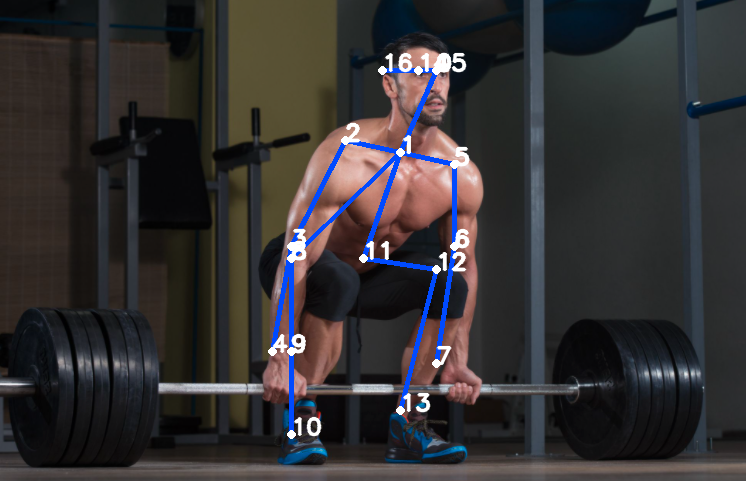

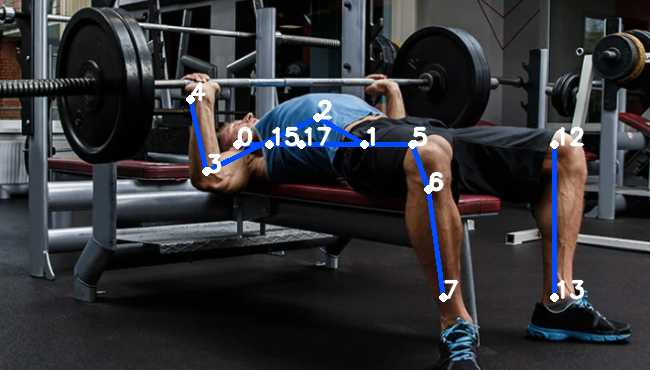

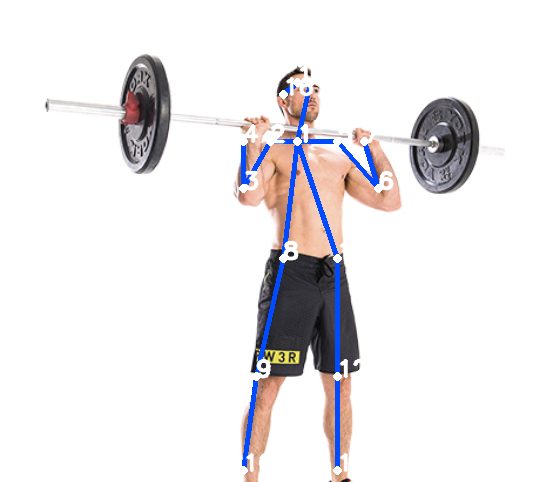

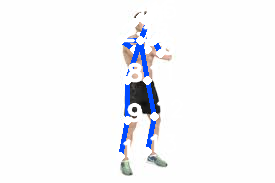

In [104]:
# This is to generate good body postures and source body geometry from them.
locations_deadlift = get_body_geometry("dataset/new_dataset/deadlift_good_2.png")
locations_bench = get_body_geometry("dataset/new_dataset/bench_good_2.png")
locations_overhead = get_body_geometry("dataset/new_dataset/overhead_good_2.png")
locations_squat= get_body_geometry("dataset/new_dataset/squat_good_4.png")

In [144]:
def angle_between_vectors(v1, v2):
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.degrees(np.arccos(dot_product))

    return angle

def distance_between_vectors(v1, v2):
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)
    return np.linalg.norm(v2 - v1)

def subtract_vectors(v1, v2):
    return (abs(v2[0] - v1[0]), abs(v2[1] - v1[1]))


def evaluate_image(image_path):

    print(image_path)
    image_tensor = image_loader_single(image_path)
    # print(image_tensor.shape)
    prediction_scores = model(image_tensor)
    # print(prediction_scores)
    class_pred = np.argmax(prediction_scores.detach().cpu().numpy())
    # print(class_pred)

    bench = deadlift = overhead = squat = False

    if class_pred == 0:
        bench = True
    if class_pred == 1:
        overhead = True
    if class_pred == 2:
        deadlift = True
    if class_pred == 3:
        squat = True

    locations = get_body_geometry(image_path)

    if deadlift: # this is the label predicted by the model
        print("Ayyy nice deadlift")
        if (distance_between_vectors(locations["RShoulder"], locations["LShoulder"]) != distance_between_vectors(locations["RAnkle"], locations["LAnkle"])):
            print("Your feet should be the same width as your shoulders")
        
        neck_to_torso = (angle_between_vectors(locations["RHip"], locations["Neck"]) + angle_between_vectors(locations["LHip"], locations["Neck"])) / 2
        torso_to_eyes = angle_between_vectors(locations["Neck"], locations["LEye"])
        if (angle_between_vectors(neck_to_torso, torso_to_eyes) < 160):
            print("Your back is too arched. Make sure to extend your chest outward.")


    elif bench:
        print("Ayyy nice bench looking swole")
        if (angle_between_vectors(subtract_vectors(locations["LElbow"], locations["LShoulder"]), subtract_vectors(locations["LShoulder"], locations["LHip"])) > 60):
            print("Elbows stretched too far wide. Bring your elbows closer to your chest.")

        if (angle_between_vectors(subtract_vectors(locations["LShoulder"], locations["LKnee"]), subtract_vectors(locations["LKnee"], locations["LAnkle"])) > 80):
            print("Your feet should be behind your knees to allow you to push. ")


    elif overhead:
        print("Ayyy nice overhead press")
        if (distance_between_vectors(locations["RShoulder"], locations["LShoulder"]) != distance_between_vectors(locations["RAnkle"], locations["LAnkle"])):
            print("Your feet should be the same width as your shoulders")
        
        if (angle_between_vectors(subtract_vectors(locations["LShoulder"], locations["LElbow"]), subtract_vectors(locations["LElbow"], locations["LWrist"])) > 25):
            print("Angle between forearm and bicep too large. Bring your forearm closer to your chest.")
    
    elif squat:
        print("Ayyy nice squat looking thicc")
        if (abs(distance_between_vectors(locations["RShoulder"], locations["LShoulder"]) - distance_between_vectors(locations["RAnkle"], locations["LAnkle"])) > 1):
            print("Your feet should be the same width as your shoulders")


torch.Size([1, 3, 256, 256])
tensor([[-382.8980, -516.3633,  108.9946, -555.4579]], device='cuda:0',
       grad_fn=<AddmmBackward>)
2


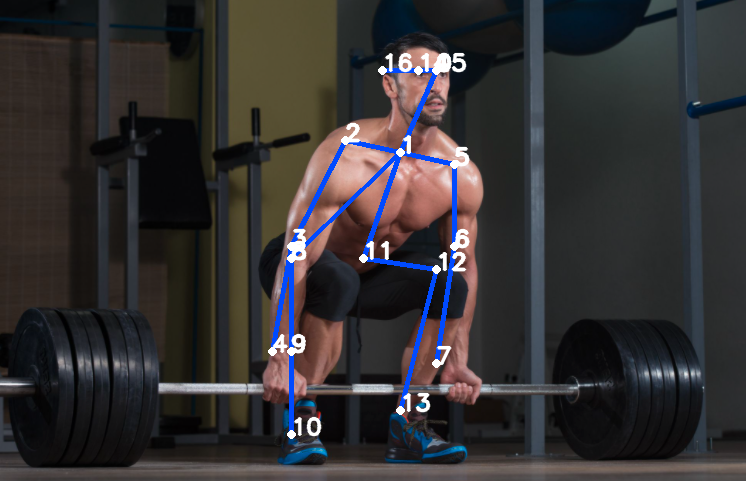




Ayyy nice deadlift


In [123]:
evaluate_image("dataset/new_dataset/deadlift_good_2.png")

torch.Size([1, 3, 256, 256])
tensor([[  46.3412,  137.9252, -689.2372, -520.9017]], device='cuda:0',
       grad_fn=<AddmmBackward>)
1


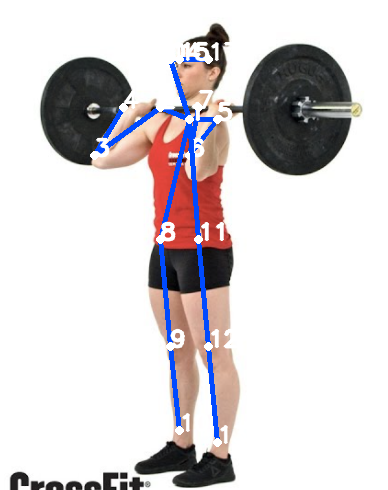




Ayyy nice overhead press
Your feet should be the same width as your shoulders
Angle between forearm and bicep too large. Bring your forearm closer to your chest.


In [124]:
evaluate_image("dataset/random_test/test_overhead_1.png")

dataset/new_dataset/bench_good_2.png
[[[105 118 153]
  [101 112 150]
  [109 118 154]
  ...
  [  6   5  15]
  [  5   5  15]
  [  5   5  15]]

 [[109 121 157]
  [106 117 159]
  [109 120 159]
  ...
  [  6   5  16]
  [  4   5  16]
  [  4   5  16]]

 [[109 119 157]
  [107 117 156]
  [106 116 150]
  ...
  [  6   6  16]
  [  5   6  17]
  [  5   6  17]]

 ...

 [[ 61  57  55]
  [ 60  56  54]
  [ 52  48  46]
  ...
  [ 64  59  60]
  [ 63  59  59]
  [ 65  60  61]]

 [[ 61  57  55]
  [ 59  55  54]
  [ 60  56  54]
  ...
  [ 64  59  60]
  [ 60  55  56]
  [ 63  58  59]]

 [[ 65  61  59]
  [ 60  56  54]
  [ 64  60  58]
  ...
  [ 69  64  65]
  [ 62  57  58]
  [ 63  58  59]]]


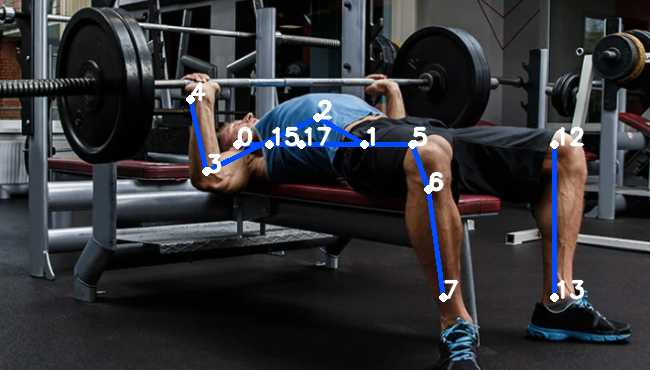




Ayyy nice bench looking swole
Elbows stretched too far wide. Bring your elbows closer to your chest.
Your feet should be behind your knees to allow you to push. 
dataset/random_test/test_bench_1.png
[[[12 11 10]
  [12 11 10]
  [10  9  7]
  ...
  [19 17 15]
  [19 17 15]
  [19 17 15]]

 [[12 11 10]
  [12 11 10]
  [10  9  7]
  ...
  [19 17 15]
  [19 17 15]
  [19 17 15]]

 [[ 9  6  5]
  [ 9  6  5]
  [10  9  7]
  ...
  [20 19 19]
  [20 19 19]
  [20 19 19]]

 ...

 [[63 62 64]
  [63 62 64]
  [33 30 32]
  ...
  [43 43 44]
  [80 81 79]
  [80 81 79]]

 [[33 29 32]
  [33 29 32]
  [35 34 35]
  ...
  [57 57 55]
  [51 51 52]
  [51 51 52]]

 [[33 29 32]
  [33 29 32]
  [35 34 35]
  ...
  [57 57 55]
  [51 51 52]
  [51 51 52]]]


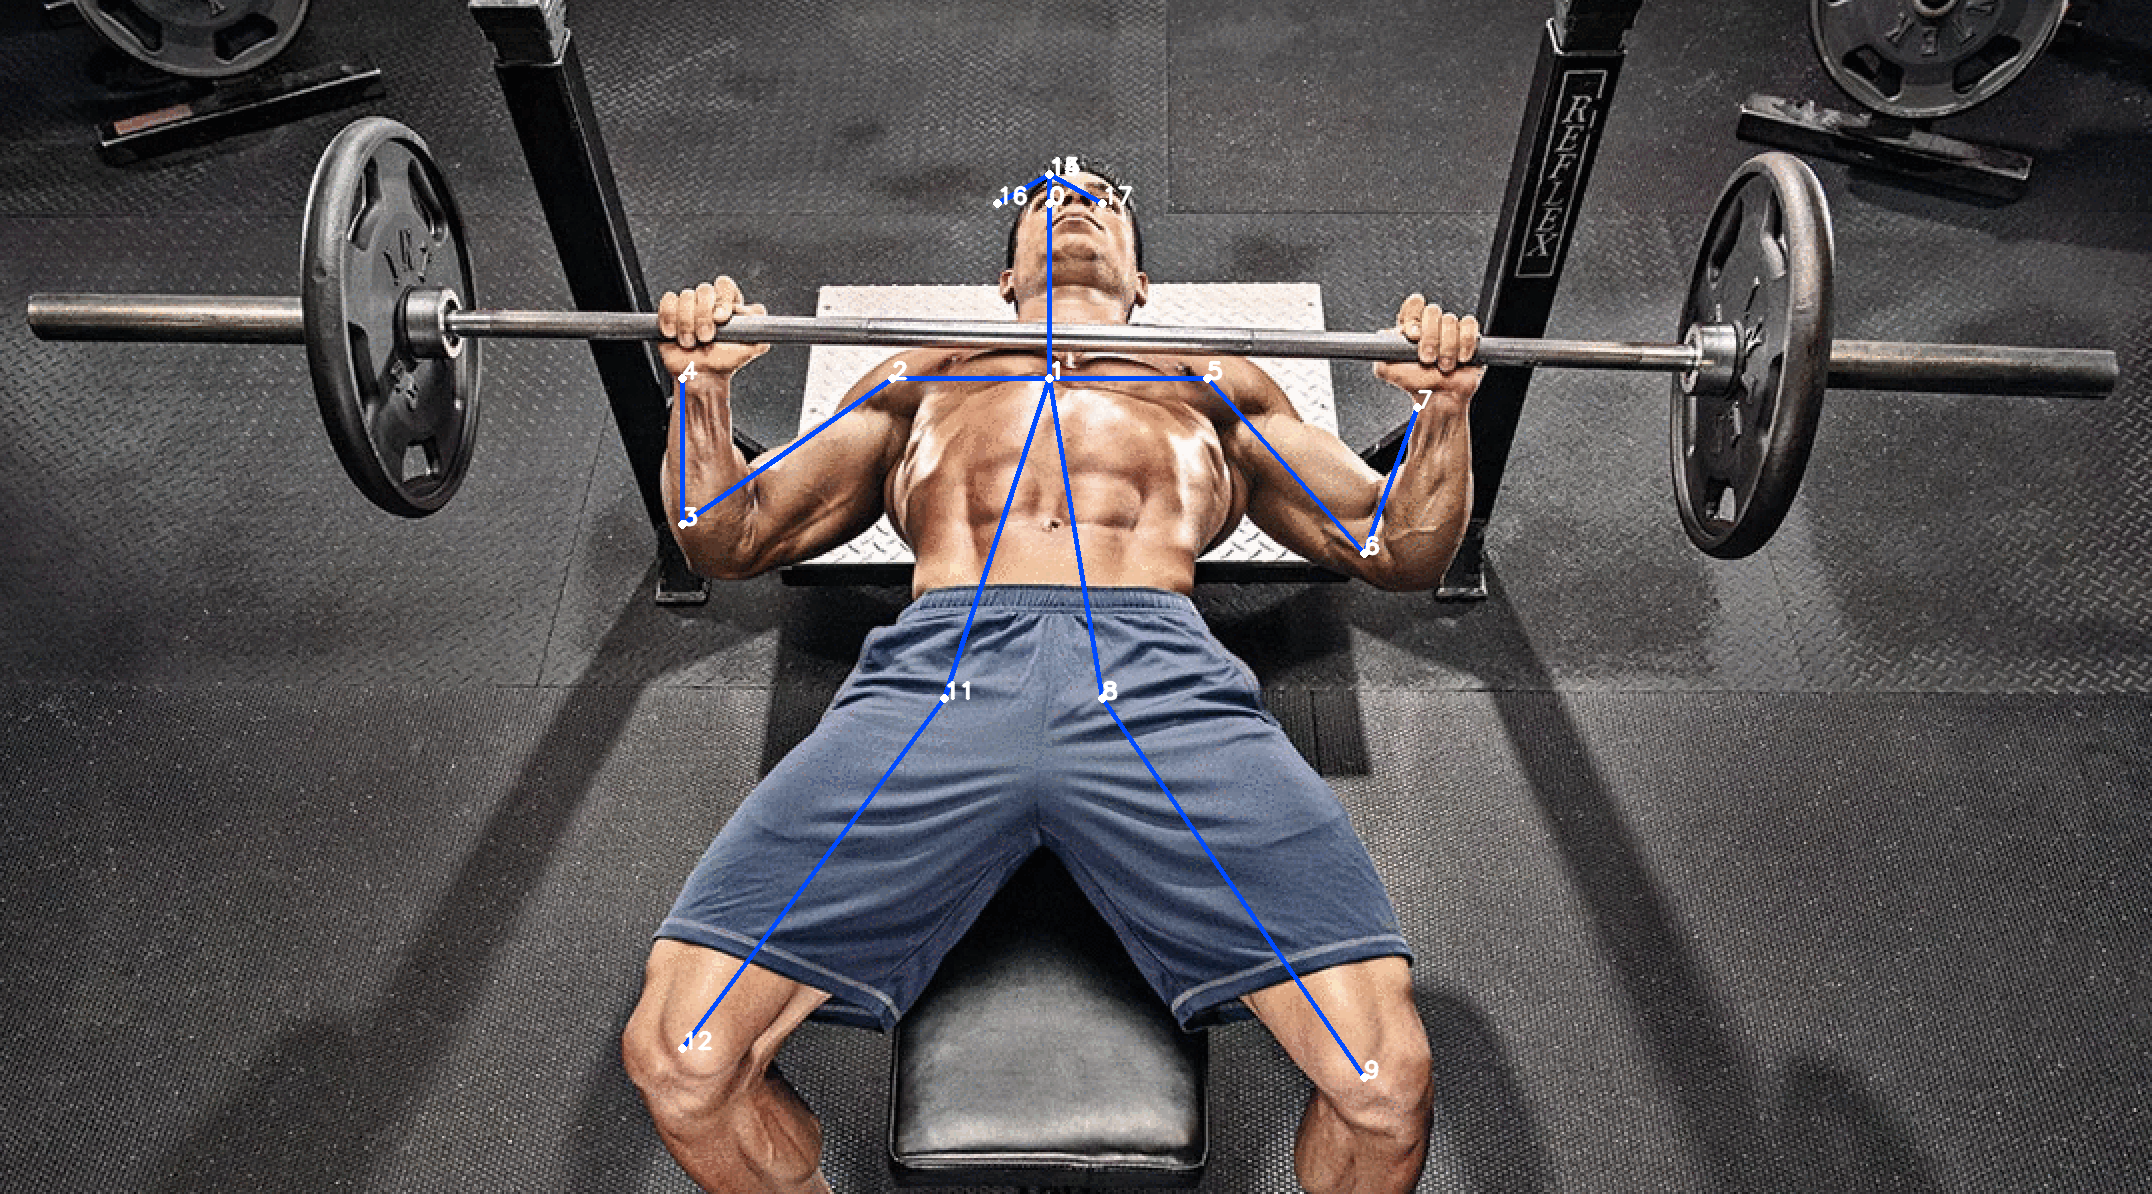




Ayyy nice bench looking swole


In [148]:
evaluate_image("dataset/new_dataset/bench_good_2.png")
evaluate_image("dataset/random_test/test_bench_1.png")

In [138]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_predicted.cpu(), test_labels.cpu())

array([[2, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])